# Cycle Fucking Gan

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from losses import discriminator_loss, generator_loss, calc_cycle_loss, identity_loss
from generator import Generator
from discriminator import Discriminator
from data_generator import load_dataset
from cycleGAN import CycleGan
import matplotlib.pyplot as plt
import re
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

gpu = len(tf.config.list_physical_devices('GPU'))>0

if gpu:
    print("GPU is", "available")
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("NOT AVAILABLE")
    
AUTOTUNE = tf.data.experimental.AUTOTUNE

GPU is available


In [2]:
GANDIDO_FILENAMES = tf.io.gfile.glob('gandido/*.jpeg')
print('Gandido Files:', len(GANDIDO_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('photo/*.jpeg')
print('Photo Files:', len(PHOTO_FILENAMES))

Gandido Files: 4580
Photo Files: 7038


In [3]:
IMAGE_SIZE = [256,256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32)/127.5) - 1
    
    image = tf.image.resize(image, IMAGE_SIZE,
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image = tf.reshape(image, [*IMAGE_SIZE,3])

    return image

def process(example):
    img = tf.io.read_file(example)

    image = decode_image(img)
    return image

In [4]:
def load_dataset(img_path, labeled=True, ordered=False):
    dataset = tf.data.Dataset.list_files(img_path)
    dataset = dataset.map(lambda x: process(x))
    return dataset

In [5]:
candido_datagen = tf.data.Dataset.list_files("./gandido/*.jpeg")
photo_datagen = tf.data.Dataset.list_files("./photo/*.jpeg")


candido_ds = candido_datagen.map(lambda x: process(x)).batch(8)

photo_ds = photo_datagen.map(lambda x: process(x)).batch(8)

In [6]:
example_candido = next(iter(candido_ds))
example_photo = next(iter(photo_ds))

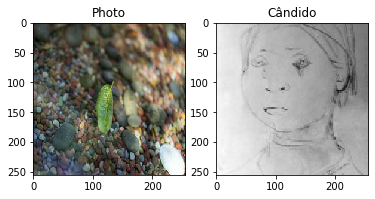

In [7]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0]* 0.5 + 0.5)

plt.subplot(122)
plt.title('Cândido')
plt.imshow(example_candido[0]* 0.5 + 0.5)

In [8]:
gandido_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

gandido_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [9]:
gandido_generator = Generator()
photo_generator = Generator()

In [10]:
gandido_discriminator = Discriminator()
photo_discriminator = Discriminator()

In [11]:
cycle_gan_model = CycleGan(
    gandido_generator, photo_generator, gandido_discriminator, photo_discriminator
)

In [12]:
cycle_gan_model.compile(
    gandido_generator_optimizer,
    photo_generator_optimizer,
    gandido_discriminator_optimizer,
    photo_discriminator_optimizer,
    generator_loss,
    discriminator_loss,
    calc_cycle_loss,
    identity_loss
)

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((candido_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
 40/573 [=>............................] - ETA: 8:00 - monet_gen_loss: 10.3955 - photo_gen_loss: 10.2837 - monet_disc_loss: 0.6628 - photo_disc_loss: 0.6508

In [ ]:
cycle_gan_model.save("best_model_mama_Aqui_Wallace.h5")